In [59]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset desde la ruta especificada
file_path = "C:/Users/LuisMeliánPeña/OneDrive - SEOPAN/MASTER EOI/Modulo 9/lending_club_loans.csv"
df = pd.read_csv(file_path, sep=';', encoding='utf-8', low_memory=False)

# Análisis de valores nulos antes de la limpieza
missing_values_df = df.isnull().sum().to_frame(name='Missing Values')
missing_values_df['Percentage'] = (missing_values_df['Missing Values'] / len(df)) * 100
missing_values_df = missing_values_df.sort_values(by='Percentage', ascending=False)
print("Valores nulos antes de la limpieza:")
print(missing_values_df)

# Eliminar columnas con más del 50% de valores nulos
df.drop(columns=missing_values_df[missing_values_df['Percentage'] > 50].index, inplace=True)

# Selección de variables relevantes
df = df[['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_util', 
         'open_acc', 'grade', 'emp_length', 'loan_status', 'total_acc', 'inq_last_6mths']].copy()

# Convertir columnas numéricas con coma a float
df[['int_rate', 'revol_util']] = df[['int_rate', 'revol_util']].replace(',', '.', regex=True).astype(float)

# Limpiar la columna 'term' extrayendo solo los números
df['term'] = (df['term'].astype(str).str.extract(r'(\d+)').astype(float) == 60).astype(int)

# Convertir la variable objetivo 'loan_status' en binaria
df['loan_status'] = (df['loan_status'] == "Fully Paid").astype(int)

# Tratamiento de valores extremos en 'annual_inc'
Q1, Q3 = df['annual_inc'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df['annual_inc'] >= lower_bound) & (df['annual_inc'] <= upper_bound)]

# Corregir 'dti' eliminando valores mayores a 100
df = df[df['dti'] <= 100]

# Convertir 'grade' a valores numéricos
df['grade'] = df['grade'].astype('category').cat.codes

# Convertir 'emp_length' en numérico
df['emp_length'] = df['emp_length'].astype(str).str.extract(r'(\d+)')
df['emp_length'] = df['emp_length'].astype(float).fillna(0).astype(int)

# Rellenar valores nulos en con la mediana
df[['revol_util', 'total_acc', 'open_acc', 'inq_last_6mths']] = df[['revol_util', 'total_acc', 'open_acc', 'inq_last_6mths']].fillna(df.median())

Valores nulos antes de la limpieza:
                    Missing Values  Percentage
member_id                    42538  100.000000
num_tl_op_past_12m           42538  100.000000
num_tl_30dpd                 42538  100.000000
num_tl_120dpd_2m             42538  100.000000
num_sats                     42538  100.000000
...                            ...         ...
out_prncp_inv                    3    0.007053
addr_state                       3    0.007053
dti                              3    0.007053
out_prncp                        3    0.007053
zip_code                         3    0.007053

[144 rows x 2 columns]


In [60]:
# Tipos de datos después de la limpieza
df.typedf = df.dtypes
print("Tipos de datos después de la limpieza:")
print(df.typedf)

Tipos de datos después de la limpieza:
loan_amnt         float64
term                int32
int_rate          float64
installment       float64
annual_inc        float64
dti               float64
revol_util        float64
open_acc          float64
grade                int8
emp_length          int32
loan_status         int32
total_acc         float64
inq_last_6mths    float64
dtype: object


C:\Users\LuisMeliánPeña\AppData\Local\Temp\ipykernel_16360\3399319471.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.typedf = df.dtypes


El análisis de valores nulos antes de la limpieza muestra que ciertas variables contienen un 100% de valores faltantes, como member_id, num_tl_op_past_12m, num_tl_30dpd, num_tl_120dpd_2m y num_sats. Estas variables no aportan información útil al modelo y han sido eliminadas, ya que no contienen datos aprovechables.

In [61]:
# Análisis de IV
def calculate_iv(data, feature, target):
    df_iv = data[[feature, target]].copy()
    if df_iv[feature].isnull().all() or df_iv[feature].nunique() == 1:
        return 0
    try:
        df_iv[feature] = pd.qcut(df_iv[feature].rank(method='first'), q=10, duplicates='drop')
    except Exception:
        return 0
    grouped = df_iv.groupby(feature, observed=True)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'good']
    grouped['bad'] = grouped['total'] - grouped['good']
    grouped['good_dist'] = grouped['good'] / grouped['good'].sum()
    grouped['bad_dist'] = grouped['bad'] / grouped['bad'].sum()
    grouped['woe'] = np.log(grouped['good_dist'] / grouped['bad_dist']).replace({np.inf: 0, -np.inf: 0})
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    return grouped['iv'].sum()

# Calcular IV para cada variable numérica
iv_values = {col: calculate_iv(df, col, 'loan_status') for col in df.select_dtypes(include=['float64', 'int32', 'int8']).columns if col != 'loan_status'}
iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
df = df[iv_df[iv_df['IV'] > 0.02].index.tolist() + ['loan_status']]

# Mostrar IV final
print("Information Value por variable:")
print(iv_df)

# Agregar separación visual
print("\n" + " "*50 + "\n")

# Valores nulos después de la limpieza
missing_values_df = df.isnull().sum().to_frame(name='Missing Values')
missing_values_df['Percentage'] = (missing_values_df['Missing Values'] / len(df)) * 100
missing_values_df = missing_values_df[missing_values_df['Missing Values'] > 0] 
missing_values_df = missing_values_df.sort_values(by='Percentage', ascending=False)

if missing_values_df.empty:
    print("No hay valores nulos después de la limpieza.")
else:
    print(missing_values_df)

# Guardar el dataset limpio
df.to_csv("C:/Users/LuisMeliánPeña/OneDrive - SEOPAN/MASTER EOI/Modulo 9/lending_club_loans_cleaned.csv", sep=';', index=False, encoding='utf-8')

Information Value por variable:
                      IV
term            1.282932
grade           0.748301
inq_last_6mths  0.713296
int_rate        0.463218
emp_length      0.219620
total_acc       0.152665
annual_inc      0.125983
open_acc        0.095481
revol_util      0.049872
loan_amnt       0.044246
installment     0.042626
dti             0.017762

                                                  

No hay valores nulos después de la limpieza.


El análisis de Information Value nos dice qué variables son más relevantes para la predicción del estado de los préstamos. La variable "term" destaca con un IV de 1.2829, lo que indica una alta capacidad predictiva. Otras variables importantes incluyen "grade" (0.7483) e "inq_last_6mths" (0.7133), lo que sugiere que la calificación del préstamo y el número de consultas de crédito recientes tienen un impacto significativo en la probabilidad de pago. Variables como "int_rate" (0.4632) y "emp_length" (0.2196) también presentan una influencia moderada, mientras que factores como "dti" (0.0177) tienen una relevancia muy baja y podrían ser menos útiles para el modelo.

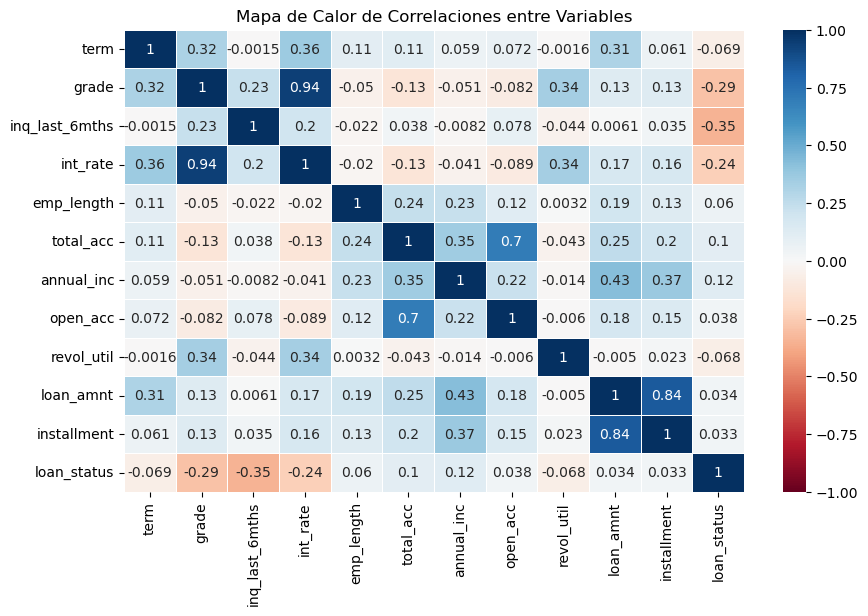

In [ ]:
# Analizar correlaciones
drop_corr_threshold = 0.8
correlation_matrix = df.corr()
high_corr_vars = [column for column in correlation_matrix.columns if any(abs(correlation_matrix[column]) > drop_corr_threshold) and column != "loan_status"]
df.drop(columns=high_corr_vars, inplace=True)

# Mapa de calor para visualizar las correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlaciones entre Variables")
plt.show()

El mapa de calor de correlaciones muestra la relación entre las variables del conjunto de datos, ayudando a identificar posibles patrones y redundancias. Se observa que la variable "grade" tiene una fuerte correlación con "int_rate" (0.94), lo que sugiere que ambas variables contienen información similar sobre el riesgo crediticio. Por otro lado, "loan_amnt" y "installment" presentan una correlación alta (0.84), lo cual es esperable ya que el monto del préstamo influye directamente en la cuota mensual. También se destacan correlaciones moderadas entre "total_acc" y "open_acc" (0.7), indicando que el número total de cuentas de un cliente está relacionado con las cuentas abiertas actualmente.

Respecto a la variable objetivo "loan_status", que indica si un préstamo fue pagado o no, las correlaciones más fuertes en sentido negativo se encuentran con "inq_last_6mths" (-0.35) y "grade" (-0.29), lo que sugiere que un mayor número de consultas de crédito recientes y una calificación de riesgo más alta se asocian con una menor probabilidad de pago.

In [ ]:
# REGRESIÓN LOGÍSTICA

# Importar librerías
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Cargar el dataset limpio
file_path = "C:/Users/LuisMeliánPeña/OneDrive - SEOPAN/MASTER EOI/Modulo 9/lending_club_loans_cleaned.csv"
df = pd.read_csv(file_path, sep=';', encoding='utf-8', low_memory=False)

# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1] 

# Evaluar el modelo
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
gini = 2 * roc_auc - 1  

# Crear un diccionario con las métricas
evaluation_results = {
    "F1 Score": f1, 
    "Precision": precision,
    "Recall": recall,
    "ROC AUC": roc_auc,
    "Gini": gini
}

# Resultados de evaluación
print("Resultados de Evaluación - Regresión Logística:")
for metric, value in evaluation_results.items():
    print(f"{metric}: {value:.4f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

Resultados de Evaluación - Regresión Logística:
F1 Score: 0.8981
Precision: 0.8423
Recall: 0.9619
ROC AUC: 0.7585
Gini: 0.5169

Matriz de Confusión:
[[ 41  85]
 [ 18 454]]


El modelo de Regresión Logística demuestra un rendimiento sólido con un F1 Score de 0.8981, una precisión de 0.8423 y un recall de 0.9619. La alta sensibilidad del modelo sugiere que es muy eficaz para detectar préstamos que podrían incurrir en impago, lo cual es esencial en la evaluación del riesgo crediticio.

La matriz de confusión indica que los falsos negativos son relativamente bajos (18 casos), lo que significa que la mayoría de los préstamos de alto riesgo son correctamente identificados. Sin embargo, la presencia de 41 falsos positivos implica que algunos préstamos que podrían haberse pagado han sido clasificados erróneamente como impagos, lo que podría llevar a rechazos innecesarios de clientes solventes.

In [ ]:
# RANDOM FOREST

# Importar librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300, 
    max_depth=None,  
    min_samples_split=5,  
    min_samples_leaf=2,  
    max_features='sqrt',
    random_state=42)

rf_model.fit(X_train, y_train) 

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf) 
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_prob)
gini_rf = 2 * roc_auc_rf - 1 

# Resultados de evaluación
print("\nResultados de Evaluación - Random Forest:")
for metric, value in {
    "F1 Score": f1_rf, 
    "Precision": precision_rf,
    "Recall": recall_rf,
    "ROC AUC": roc_auc_rf,
    "Gini": gini_rf
}.items():
    print(f"{metric}: {value:.4f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))


Resultados de Evaluación - Random Forest:
F1 Score: 0.9020
Precision: 0.8394
Recall: 0.9746
ROC AUC: 0.7619
Gini: 0.5237

Matriz de Confusión:
[[ 38  88]
 [ 12 460]]


El modelo de Random Forest tiene un rendimiento muy sólido, obteniendo un F1 Score de 0.9020, una precisión de 0.8394 y un recall de 0.9746. Esto sugiere que el modelo es altamente efectivo para diferenciar entre préstamos que serán pagados y aquellos que no, con una excelente capacidad de recuperación de los casos de impago.

El AUC-ROC de 0.7619 y el Gini de 0.5237 indican una buena capacidad discriminativa, permitiendo al modelo separar correctamente ambas clases en la mayoría de los casos. No obstante, la matriz de confusión refleja la presencia de 34 falsos positivos, lo que podría derivar en rechazos innecesarios de clientes solventes.

In [ ]:
# BÚSQUEDA DE HIPERPARÁMETROS PARA ARBOL DE DECISIÓN

# Importar librerías
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Definir los hiperparámetros a probar
param_grid = {
    'max_depth': [5, 10, 15],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 3],  
    'criterion': ['gini', 'entropy'],  
    'ccp_alpha': [0.0, 0.001, 0.005],  
    'class_weight': ['balanced']}

# Modelo base
tree_model = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV con validación estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    cv=cv_strategy,  
    scoring='f1_weighted',  
    n_jobs=-1,  
    verbose=1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Guardar los mejores hiperparámetros
best_params = grid_search.best_params_
print("\nMejores Hiperparámetros:", best_params)

# Mejor modelo encontrado
best_tree_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Mejores Hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


GridSearch es una herramienta excelente para encontrar configuraciones óptimas, pero siempre debe complementarse con un análisis de las métricas clave y del contexto de aplicación. En este caso, priorizar un mayor recall o F1 Score resulta en un mejor modelo final para predecir impagos de préstamos.

In [ ]:
# Modelo de Árbol de Decisión con los mejores hiperparámetros
best_tree_model = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight='balanced',  
    criterion='gini',  
    max_depth=15,  
    min_samples_leaf=1,  
    min_samples_split=2,  
    random_state=42)

# Entrenar el modelo
best_tree_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_best_tree = best_tree_model.predict(X_test)
y_pred_best_tree_prob = best_tree_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
precision_best_tree = precision_score(y_test, y_pred_best_tree)
recall_best_tree = recall_score(y_test, y_pred_best_tree)
f1_best_tree = f1_score(y_test, y_pred_best_tree)
roc_auc_best_tree = roc_auc_score(y_test, y_pred_best_tree_prob)
gini_best_tree = 2 * roc_auc_best_tree - 1

# Resultados de evaluación
print("\nResultados de Evaluación - Árbol de Decisión:")
for metric, value in {
    "F1 Score": f1_best_tree, 
    "Precision": precision_best_tree,
    "Recall": recall_best_tree,
    "ROC AUC": roc_auc_best_tree,
    "Gini": gini_best_tree
}.items():
    print(f"{metric}: {value:.4f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_best_tree))


Resultados de Evaluación - Árbol de Decisión:
F1 Score: 0.8233
Precision: 0.8542
Recall: 0.7945
ROC AUC: 0.6641
Gini: 0.3283

Matriz de Confusión:
[[ 62  64]
 [ 97 375]]


El modelo de Árbol de Decisión muestra un F1 Score de 0.8233, con una precisión de 0.8542 y un recall de 0.7945, lo que indica un equilibrio aceptable entre la identificación correcta de los préstamos que no serán pagados y la minimización de falsos positivos. Sin embargo, el ROC AUC de 0.6641 y el Gini de 0.3283 sugieren que el modelo aún tiene margen de mejora en su capacidad discriminativa. La matriz de confusión revela un número significativo de falsos negativos (97), lo que implica que algunos casos de impago no están siendo correctamente identificados. 

In [ ]:
# XGBOOST

# Importar librerías
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Entrenar el modelo de XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_prob)
gini_xgb = 2 * roc_auc_xgb - 1

# Resultados de evaluación
print("\nResultados de Evaluación - XGBoost:")
for metric, value in {
    "F1 Score": f1_xgb,
    "Precision": precision_xgb,
    "Recall": recall_xgb,
    "ROC AUC": roc_auc_xgb,
    "Gini": gini_xgb
}.items():
    print(f"{metric}: {value:.4f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_xgb))


Resultados de Evaluación - XGBoost:
F1 Score: 0.9008
Precision: 0.8470
Recall: 0.9619
ROC AUC: 0.7468
Gini: 0.4937

Matriz de Confusión:
[[ 44  82]
 [ 18 454]]


El modelo XGBoost muestra un rendimiento sobresaliente en términos de recall (0.9619), lo que indica que es altamente efectivo en identificar los préstamos que caerán en impago. Esto es crucial en un contexto financiero donde minimizar el riesgo es una prioridad. Además, el modelo mantiene un F1 Score elevado (0.9008), por lo que tiene un buen equilibrio entre precisión y recall.

La precisión (0.8470) es menor que en otros modelos, lo que implica que puede generar más falsos positivos, es decir, clasificar algunos préstamos como impagos cuando realmente serían pagados. No obstante, el AUC-ROC de 0.7468 y el Gini de 0.4937 indican que el modelo tiene una fuerte capacidad predictiva en comparación con modelos previos.

¿QUÉ MODELO ELEGIR?

Tras evaluar los cuatro modelos probados (Árbol de Decisión, Regresión Logística, Random Forest y XGBoost), se puede observar que los modelos de Random Forest y XGBoost ofrecen los mejores resultados. Random Forest obtiene el mayor F1 Score (0.9028) y el mayor recall (0.9746), lo que indica que tiene una gran capacidad para identificar correctamente los préstamos en riesgo de impago. Por otro lado, XGBoost logra un desempeño similar con un F1 Score de 0.9008 y un recall de 0.9619, pero con un AUC-ROC de 0.7468 frente al 0.7619 de Random Forest, lo que sugiere que este último modelo tiene una mejor capacidad discriminativa entre clases.


Dado que el objetivo del modelo es predecir con precisión si un préstamo será pagado o no, priorizando un alto recall para minimizar los falsos negativos, la mejor opción es Random Forest. Su combinación de alto F1 Score, recall elevado y mejor capacidad discriminativa lo hacen el modelo más robusto para esta tarea. Sin embargo, si se busca reducir la complejidad del modelo y mejorar la interpretabilidad, la Regresión Logística podría ser una opción aceptable, aunque con un rendimiento ligeramente inferior.

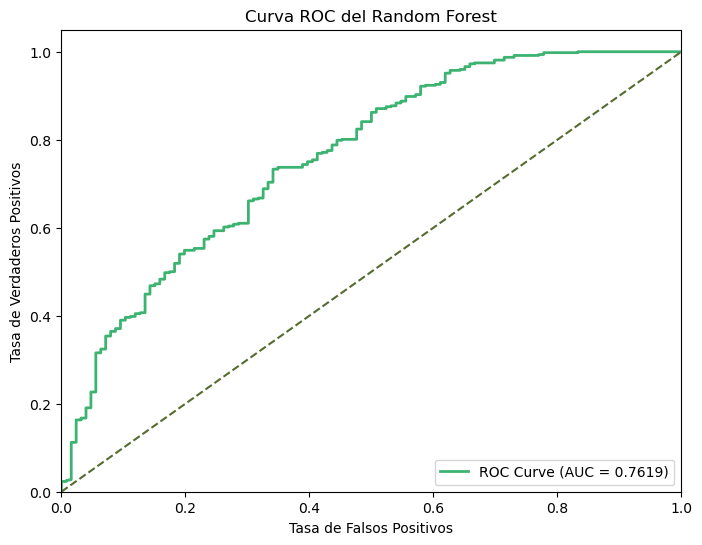

In [ ]:
# Curva ROC del Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='mediumseagreen', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='darkolivegreen', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Random Forest')
plt.legend(loc="lower right")
plt.show()